In [1]:
%matplotlib inline
from __future__ import division  # just in case you are still using python2
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid', 'seaborn-colorblind'])
import statsmodels.formula.api as smf 

#### Code 7.1

In [2]:
d = pd.read_csv('Data/rugged.csv', sep=';', header=0)
#d.head()

# make log version of outcome
d.log_gdp = np.log(d.rgdppc_2000)

# extract countries with GDP data
dd = d[np.isfinite(d['rgdppc_2000'])]

# split countries into Africa and non-Africa
d.A1 = dd[dd.cont_africa==1]  # Africa
d.A0 = dd[dd.cont_africa==0]  # not Africa

#### Code 7.2

In [3]:
# Fit the regression models with this code.
# African nations
with pm.Model() as model_7_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * d.A1['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A1['rgdppc_2000']))
    trace_7_2 = pm.sample(1000)

100%|██████████| 1500/1500 [00:08<00:00, 175.87it/s]


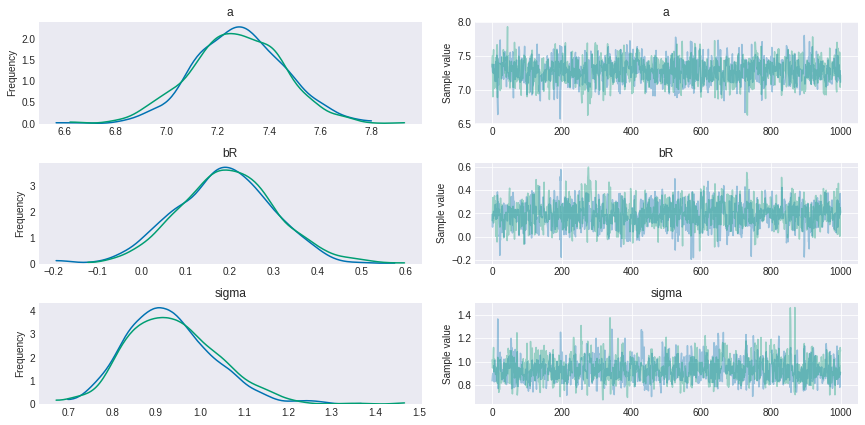

In [4]:
varnames = ['a', 'bR', 'sigma']
pm.traceplot(trace_7_2, varnames);

In [5]:
# non-African nations
with pm.Model() as model_7_2_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * d.A0['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A0['rgdppc_2000']))
    trace_7_2_2 = pm.sample(1000)

100%|██████████| 1500/1500 [00:17<00:00, 87.23it/s]


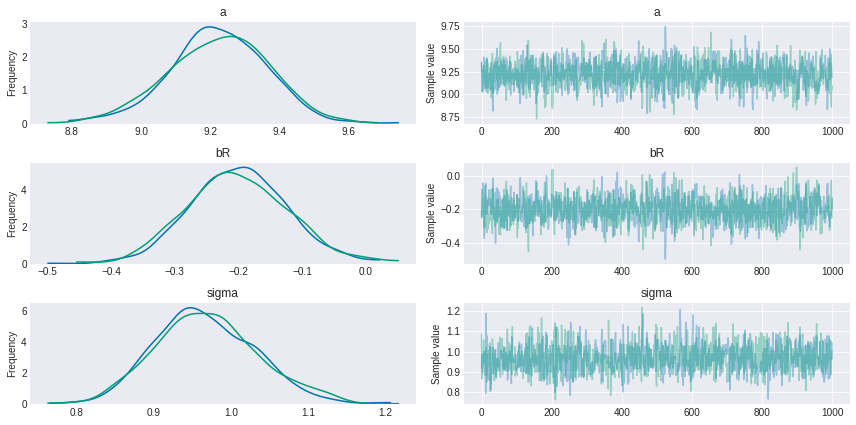

In [6]:
pm.traceplot(trace_7_2_2, varnames);

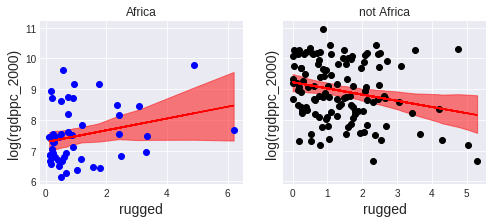

In [7]:
# Plot the data

mu_mean = trace_7_2['mu']
mu_hpd = pm.hpd(mu_mean)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'bo')
ax1.plot(d.A1['rugged'], mu_mean.mean(0), 'r')
idx = np.argsort(d.A1['rugged'])
# I used .sort_values() as it does a better job at sorting them as opposed to indexing a sorted list.
ax1.fill_between(d.A1['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)
ax1.set_title('Africa')
ax1.set_ylabel('log(rgdppc_2000)', fontsize=14);
ax1.set_xlabel('rugged', fontsize=14)

mu_mean = trace_7_2_2['mu']
mu_hpd = pm.hpd(mu_mean)

ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(d.A0['rugged'], mu_mean.mean(0), 'r')
ax2.set_title('not Africa')
ax2.set_ylabel('log(rgdppc_2000)', fontsize=14)
ax2.set_xlabel('rugged', fontsize=14)
idx = np.argsort(d.A0['rugged'])
ax2.fill_between(d.A0['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5);

#### Code 7.3

In [8]:
# Model the entire data
with pm.Model() as model_7_3:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_3 = pm.sample(1000)

100%|██████████| 1500/1500 [00:16<00:00, 91.85it/s]
/home/agustina/anaconda3/lib/python3.5/site-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.890729042427, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


#### Code 7.4

In [9]:
# Model the entire data including a dummy variable
with pm.Model() as model_7_4:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_4 = pm.sample(1000)

100%|█████████▉| 1498/1500 [00:19<00:00, 77.98it/s]/home/agustina/anaconda3/lib/python3.5/site-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.881728991759, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1500/1500 [00:19<00:00, 77.67it/s]


#### Code 7.5

WAIC values are point estimates and hence is a good idea to include the uncertainty asociated with their estimation when computing weights. PyMC3 uses a Bayesian bootstrapping to do this (read more [here](https://arxiv.org/abs/1704.02030)), and also to compute the standard error (SE) of WAIC/LOO estimates. If you set `bootstrapping = False` weights (and SE) will be computed as in the book.

In [10]:
comp_df = pm.compare([trace_7_3, trace_7_4], [model_7_3, model_7_4])
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,476.31,4.27,0,0.97,14.78,0,1
0,539.46,2.56,63.15,0.03,12.88,14.57,0


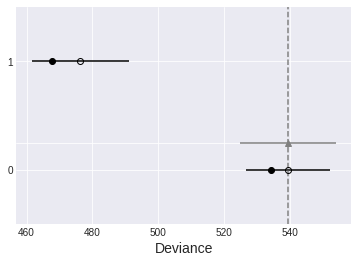

In [11]:
pm.compareplot(comp_df);

#### Code 7.6

Since the link function isn't implemented we have to compute the mean over samples ourselves using a loop.

In [12]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_4['bR'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_4['bR'])))

for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 1 

In [13]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T, alpha=0.03)

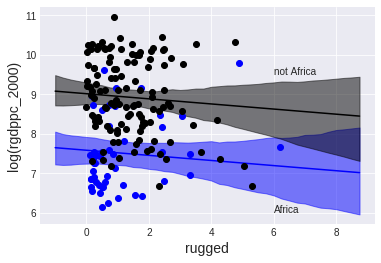

In [14]:
plt.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'bo')
plt.plot(rugged_seq, mu_mean_Africa, 'b')
plt.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='b', alpha=0.5)
plt.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
plt.plot(rugged_seq, mu_mean_NotAfrica, 'k')
plt.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
plt.annotate('not Africa', xy=(6, 9.5))
plt.annotate('Africa', xy=(6, 6))
plt.ylabel('log(rgdppc_2000)', fontsize=14)
plt.xlabel('rugged', fontsize=14);

#### Code 7.7

In [15]:
with pm.Model() as model_7_5:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    gamma = bR + bAR * dd.cont_africa
    mu = pm.Deterministic('mu', a + gamma * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5 = pm.sample(1000)

100%|██████████| 1500/1500 [00:30<00:00, 48.49it/s]


#### Code 7.8

In [16]:
comp_df = pm.compare([trace_7_3, trace_7_4, trace_7_5], [model_7_3, model_7_4, model_7_5])
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
2,469.62,5.16,0,0.91,14.56,0,1
1,476.31,4.27,6.69,0.09,14.78,6.04,1
0,539.46,2.56,69.84,0,12.88,14.65,0


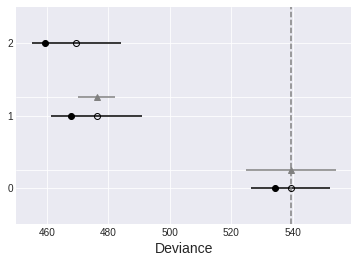

In [17]:
pm.compareplot(comp_df);

#### Code 7.9

In [18]:
with pm.Model() as model_7_5b:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR*dd.rugged + bAR*dd.rugged*dd.cont_africa + bA*dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5b = pm.sample(1000)

100%|██████████| 1500/1500 [00:34<00:00, 42.98it/s]


#### Code 7.10
First calculate the necessary posterior predicted means. The link function is replaced by a loop. We'll use model 7.5b since it's a one-liner.


In [19]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_5b['bR'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_5b['bR'])))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*0 +\
                              trace_7_5b['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*1 +\
                              trace_7_5b['bA'] * 1

In [20]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T, alpha=0.03)

#### Code 7.11

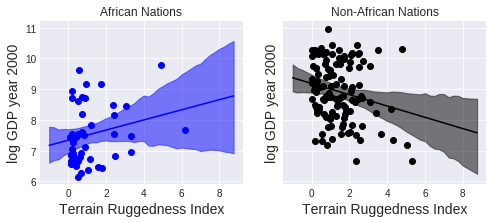

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'bo')
ax1.plot(rugged_seq, mu_mean_Africa, 'b')
ax1.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='b', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(rugged_seq, mu_mean_NotAfrica, 'k')
ax2.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14);

#### Code 7.12

In [22]:
varnames = ['a', 'bA', 'bR', 'bAR', 'sigma']
pm.df_summary(trace_7_5b, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,9.184257,0.134752,0.003775,8.902862,9.438445
bA,-1.847225,0.218909,0.005909,-2.292424,-1.454011
bR,-0.183713,0.075906,0.002261,-0.342178,-0.042976
bAR,0.348646,0.127383,0.003809,0.117452,0.606228
sigma,0.952456,0.052108,0.001238,0.849237,1.050303


#### Code 7.13

In [23]:
gamma_Africa = trace_7_5b['bR'] + trace_7_5b['bAR'] * 1
gamma_notAfrica = trace_7_5b['bR']

#### Code 7.14

In [24]:
print("Gamma within Africa: {:.2f}".format(gamma_Africa.mean()))
print("Gamma outside Africa: {:.2f}".format(gamma_notAfrica.mean()))

Gamma within Africa: 0.16
Gamma outside Africa: -0.18


#### Code 7.15

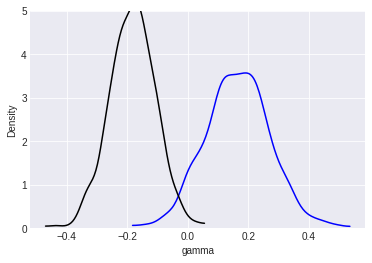

In [25]:
_, ax = plt.subplots()
ax.set_xlabel('gamma')
ax.set_ylabel('Density')
ax.set_ylim(top=5)
pm.kdeplot(gamma_Africa, color='b', ax=ax)
pm.kdeplot(gamma_notAfrica, color='k', ax=ax);

#### Code 7.16

(array([ 1.,  0.,  0., ...,  0.,  0.,  1.]),
 array([-0.06774588, -0.06730359, -0.0668613 , ...,  0.81595041,
         0.8163927 ,  0.81683499]),
 <a list of 2000 Patch objects>)

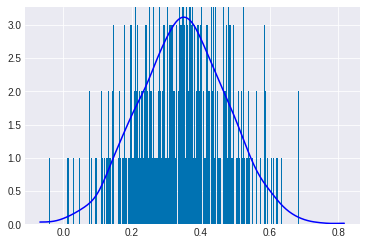

In [26]:
diff = gamma_Africa - gamma_notAfrica
# First let's plot a histogram and a kernel densitiy estimate.
pm.kdeplot(diff, color='b')
plt.hist(diff, bins=len(diff));
# Notice that there are very few values below zero.

Hence the probability to have a negative slope association ruggedness with log-GDP inside Africa is so small, it might just be zero.

In [27]:
sum(diff[diff < 0]) / len(diff)

-8.7647476761140234e-05

#### Code 7.17
Plot the reverse interpretation: The influence of being in Africa depends upon terrain ruggedness.

This places `cont_africa` on the horizontal axis, while using different lines for different values of `rugged`.

In [28]:
# Get min and max rugged values.
q_rugged = [0, 0]
q_rugged[0] = np.min(dd.rugged)
q_rugged[1] = np.max(dd.rugged)

In [29]:
# Compute lines and confidence intervals.
# Since the link function isn't implemented we have to again compute the mean over samples ourselves using a loop.
mu_ruggedlo = np.zeros((2, len(trace_7_5b['bR'])))
mu_ruggedhi = np.zeros((2, len(trace_7_5b['bR'])))
# Iterate over outside Africa (0) and inside Africa (1).
for iAfri in range(0,2):
    mu_ruggedlo[iAfri] = trace_7_5b['a'] + trace_7_5b['bR'] * q_rugged[0] + \
                              trace_7_5b['bAR'] * q_rugged[0] * iAfri + \
                              trace_7_5b['bA'] * iAfri
    mu_ruggedhi[iAfri] = trace_7_5b['a'] + trace_7_5b['bR'] * q_rugged[1] + \
                              trace_7_5b['bAR'] * q_rugged[1] * iAfri + \
                              trace_7_5b['bA'] * iAfri

In [30]:
mu_ruggedlo_mean = np.mean(mu_ruggedlo, axis=1)
mu_hpd_ruggedlo = pm.hpd(mu_ruggedlo.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_ruggedhi_mean = np.mean(mu_ruggedhi, axis=1)
mu_hpd_ruggedhi = pm.hpd(mu_ruggedhi.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03

In [31]:
# Source http://matplotlib.org/examples/pylab_examples/spine_placement_demo.html
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))  # outward by 5 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

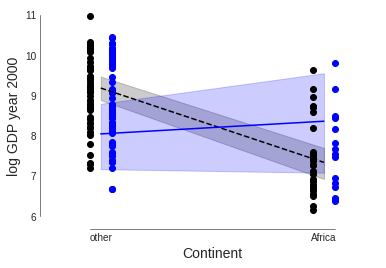

In [32]:
# Plot it all, splitting points at median
med_r = np.median(dd.rugged)
# Use list comprehension to split points at median
ox = [0.05 if x > med_r else -0.05 for x in dd.rugged]
idxk = [i for i,x in enumerate(ox) if x == -0.05]
idxb = [i for i,x in enumerate(ox) if x == 0.05]
cont_africa_ox = dd.cont_africa + ox
plt.plot(cont_africa_ox[dd.cont_africa.index[idxk]], np.log(dd.rgdppc_2000[dd.cont_africa.index[idxk]]), 'ok')
plt.plot(cont_africa_ox[dd.cont_africa.index[idxb]], np.log(dd.rgdppc_2000[dd.cont_africa.index[idxb]]), 'ob')
plt.plot([0, 1], mu_ruggedlo_mean, '--k')
plt.plot([0, 1], mu_ruggedhi_mean, 'b')
plt.fill_between([0, 1], mu_hpd_ruggedlo[:,0], mu_hpd_ruggedlo[:,1], color='k', alpha=0.2)
plt.fill_between([0, 1], mu_hpd_ruggedhi[:,0], mu_hpd_ruggedhi[:,1], color='b', alpha=0.2)
plt.ylabel('log GDP year 2000', fontsize=14);
plt.xlabel('Continent', fontsize=14)
axes = plt.gca()
axes.set_xlim([-0.25, 1.25])
axes.set_ylim([5.8, 11.2])
axes.set_xticks([0, 1])
axes.set_xticklabels(['other', 'Africa'], fontsize=12)
axes.set_facecolor('white')
adjust_spines(axes, ['left', 'bottom'])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_linewidth(0.5)
axes.spines['left'].set_linewidth(0.5)
axes.spines['bottom'].set_color('black')
axes.spines['left'].set_color('black');

#### Code 7.16

In [33]:
d = pd.read_csv('Data/tulips.csv', sep=';', header=0)
d.info()
d.head()
d.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
bed       27 non-null object
water     27 non-null int64
shade     27 non-null int64
blooms    27 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 944.0+ bytes


,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


#### Code 7.19

In [34]:
with pm.Model() as model_7_6:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water + bS*d.shade)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_6 = pm.sample(1000)

100%|██████████| 1500/1500 [01:02<00:00, 24.19it/s]


In [35]:
with pm.Model() as model_7_7:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water + bS*d.shade + bWS*d.water*d.shade)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_7 = pm.sample(1000)

100%|██████████| 1500/1500 [01:35<00:00, 15.65it/s]


In [36]:
map_7_6 = pm.find_MAP(model=model_7_6)
map_7_6

logp = -175.26, ||grad|| = 0.0011502: 100%|██████████| 24/24 [00:00<00:00, 377.14it/s]  


{'a': array(44.02992947748392),
 'bS': array(-34.779207147364616),
 'bW': array(76.44616379166348),
 'mu': array([  85.69688612,   50.91767897,   16.13847183,  162.14304991,
         127.36384277,   92.58463562,  238.58921371,  203.81000656,
         169.03079941,   85.69688612,   50.91767897,   16.13847183,
         162.14304991,  127.36384277,   92.58463562,  238.58921371,
         203.81000656,  169.03079941,   85.69688612,   50.91767897,
          16.13847183,  162.14304991,  127.36384277,   92.58463562,
         238.58921371,  203.81000656,  169.03079941]),
 'sigma': array(100.0),
 'sigma_interval__': array(19.99194662016696)}

In [37]:
map_7_7 = pm.find_MAP(model=model_7_7)
map_7_7

logp = -170.17, ||grad|| = 0.012971: 100%|██████████| 54/54 [00:00<00:00, 192.31it/s]    


{'a': array(-84.31089711150213),
 'bS': array(34.98360479830486),
 'bW': array(151.00906587541144),
 'bWS': array(-39.503172182097416),
 'mu': array([  62.17860138,   57.659034  ,   53.13946661,  173.68449507,
         129.66175551,   85.63901594,  285.19038877,  201.66447702,
         118.13856527,   62.17860138,   57.659034  ,   53.13946661,
         173.68449507,  129.66175551,   85.63901594,  285.19038877,
         201.66447702,  118.13856527,   62.17860138,   57.659034  ,
          53.13946661,  173.68449507,  129.66175551,   85.63901594,
         285.19038877,  201.66447702,  118.13856527]),
 'sigma': array(46.25354100125485),
 'sigma_interval__': array(-0.1501397625275427)}

#### Code 7.20
You can use the modified Powell's method if it fails with BFGS (default MAP estimate)

In [38]:
from scipy import optimize
map_7_6 = pm.find_MAP(model=model_7_6, fmin=optimize.fmin_powell)
map_7_6

/home/agustina/anaconda3/lib/python3.5/site-packages/pymc3-3.2-py3.5.egg/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -170.22:   4%|▍         | 222/5000 [00:00<00:10, 437.22it/s]    

Optimization terminated successfully.
         Current function value: 170.221855
         Iterations: 4
         Function evaluations: 223


logp = -170.22:   4%|▍         | 223/5000 [00:00<00:17, 278.88it/s]


{'a': array(88.09372839795003),
 'bS': array(-38.86994299187802),
 'bW': array(58.994021018079586),
 'mu': array([ 108.21780642,   69.34786343,   30.47792044,  167.21182744,
         128.34188445,   89.47194146,  226.20584846,  187.33590547,
         148.46596248,  108.21780642,   69.34786343,   30.47792044,
         167.21182744,  128.34188445,   89.47194146,  226.20584846,
         187.33590547,  148.46596248,  108.21780642,   69.34786343,
          30.47792044,  167.21182744,  128.34188445,   89.47194146,
         226.20584846,  187.33590547,  148.46596248]),
 'sigma': array(58.82119773834433),
 'sigma_interval__': array(0.3565786799536788)}

In [39]:
map_7_7 = pm.find_MAP(model=model_7_7, fmin=optimize.fmin_powell)
map_7_7

/home/agustina/anaconda3/lib/python3.5/site-packages/pymc3-3.2-py3.5.egg/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -176.57:  13%|█▎        | 630/5000 [00:01<00:08, 492.37it/s]    

Optimization terminated successfully.
         Current function value: 176.337360
         Iterations: 10
         Function evaluations: 639


logp = -176.57:  13%|█▎        | 639/5000 [00:01<00:11, 389.84it/s]


{'a': array(98.23420593023953),
 'bS': array(-41.50750243537318),
 'bW': array(53.39247436470613),
 'bWS': array(1.5739599063168825),
 'mu': array([ 111.69313777,   71.75959524,   31.82605271,  166.65957204,
         128.29998941,   89.94040679,  221.62600631,  184.84038359,
         148.05476088,  111.69313777,   71.75959524,   31.82605271,
         166.65957204,  128.29998941,   89.94040679,  221.62600631,
         184.84038359,  148.05476088,  111.69313777,   71.75959524,
          31.82605271,  166.65957204,  128.29998941,   89.94040679,
         221.62600631,  184.84038359,  148.05476088]),
 'sigma': array(60.02679450105809),
 'sigma_interval__': array(0.40658167042545007)}

#### Code 7.21
`conftab` is not implemented in PyMC3, something similar is to use `df_summary()`

In [40]:
pm.df_summary(trace_7_6, varnames=['a', 'bW', 'bS', 'sigma'])['mean']

a        51.838382
bW       76.403963
bS      -38.232034
sigma    63.550846
Name: mean, dtype: float64

In [41]:
pm.df_summary(trace_7_7, varnames=['a', 'bW', 'bS', 'sigma', 'bWS'])['mean']

a        -71.033193
bW       144.814923
bS        28.975140
sigma     53.013136
bWS      -36.778540
Name: mean, dtype: float64

#### Code 7.22

In [42]:
pm.compare([trace_7_6, trace_7_7], [model_7_6, model_7_7])

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,293.95,4.06,0,1,7.04,0,1
0,303.81,3.72,9.86,0,6.96,3.89,1


#### 7.23
Center and re-estimate

In [43]:
d.shade_c = d.shade - np.mean(d.shade)
d.water_c = d.water - np.mean(d.water)

#### 7.24
No interaction.

In [44]:
with pm.Model() as model_7_8:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water_c + bS*d.shade_c)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_8 = pm.sample(1000)
    start = {'a':np.mean(d.blooms), 'bW':0, 'bS':0, 'sigma':np.std(d.blooms)}

100%|██████████| 1500/1500 [00:13<00:00, 111.97it/s]


Interaction.

In [45]:
with pm.Model() as model_7_9:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water_c + bS*d.shade_c + bWS*d.water_c*d.shade_c)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_9 = pm.sample(1000)
    start = {'a':np.mean(d.blooms), 'bW':0, 'bS':0, 'bWS':0, 'sigma':np.std(d.blooms)}

100%|██████████| 1500/1500 [00:30<00:00, 49.19it/s]


In [46]:
map_7_8 = pm.find_MAP(model=model_7_8)
map_7_8

logp = -196.39, ||grad|| = 0.32474: 100%|██████████| 16/16 [00:00<00:00, 312.89it/s]  


{'a': array(124.38684954932732),
 'bS': array(-39.413174004672214),
 'bW': array(71.81213461600444),
 'mu': array([  91.98788894,   52.57471493,   13.16154093,  163.80002355,
         124.38684955,   84.97367554,  235.61215817,  196.19898417,
         156.78581016,   91.98788894,   52.57471493,   13.16154093,
         163.80002355,  124.38684955,   84.97367554,  235.61215817,
         196.19898417,  156.78581016,   91.98788894,   52.57471493,
          13.16154093,  163.80002355,  124.38684955,   84.97367554,
         235.61215817,  196.19898417,  156.78581016]),
 'sigma': array(100.0),
 'sigma_interval__': array(48.62145626223427)}

In [47]:
map_7_9 = pm.find_MAP(model=model_7_9)
map_7_9

logp = -201.51, ||grad|| = 0.32861: 100%|██████████| 18/18 [00:00<00:00, 291.09it/s]  


{'a': array(124.38693169605965),
 'bS': array(-39.413389496480114),
 'bW': array(71.81252724935885),
 'bWS': array(-48.78655415259237),
 'mu': array([  43.20123979,   52.57440445,   61.9475691 ,  163.80032119,
         124.3869317 ,   84.9735422 ,  284.39940259,  196.19945895,
         107.9995153 ,   43.20123979,   52.57440445,   61.9475691 ,
         163.80032119,  124.3869317 ,   84.9735422 ,  284.39940259,
         196.19945895,  107.9995153 ,   43.20123979,   52.57440445,
          61.9475691 ,  163.80032119,  124.3869317 ,   84.9735422 ,
         284.39940259,  196.19945895,  107.9995153 ]),
 'sigma': array(100.0),
 'sigma_interval__': array(50.89448124858069)}

#### 7.25

In [48]:
map_7_7['a'] + map_7_7['bW'] * 2 + map_7_7['bS'] * 2 + map_7_7['bWS'] * 2 * 2

128.29998941417296

#### 7.26

In [49]:
map_7_9['a'] + map_7_9['bW'] * 0 + map_7_9['bS'] * 0 + map_7_9['bWS'] * 0 * 0

124.38693169605965

#### 7.27

In [50]:
varnames = ['a', 'bW', 'bS', 'bWS', 'sigma']
pm.df_summary(trace_7_9, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,127.243470,9.784038,0.213354,107.777757,145.993031
bW,74.289432,12.334694,0.254145,49.721370,97.374984
bS,-41.029778,12.640444,0.249275,-64.925417,-14.270296
bWS,-51.749303,15.775758,0.323327,-83.012999,-21.195215
sigma,52.252597,8.416959,0.205750,37.423413,68.649025


#### 7.28

We have to replace the `link` function with a loop.

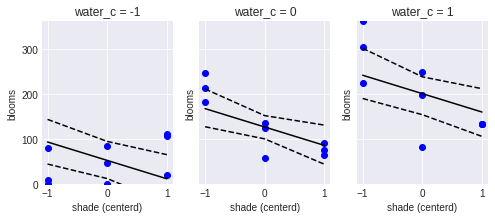

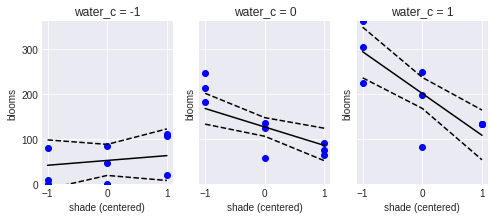

In [51]:
# No interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
shade_seq = range(-1, 2, 1)

mu_w = np.zeros((len(shade_seq), len(trace_7_8['a'])))
for ax, w in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.water_c == w]
    ax.plot(dt.shade-np.mean(dt.shade), dt.blooms, 'bo')
    for x, iSeq in enumerate(shade_seq):
        mu_w[x] = trace_7_8['a'] + trace_7_8['bW']*w + trace_7_8['bS']*iSeq
    mu_mean_w = mu_w.mean(1)
    mu_hpd_w = pm.hpd(mu_w.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(shade_seq, mu_mean_w, 'k')
    ax.plot(shade_seq, mu_hpd_w.T[0], '--k')
    ax.plot(shade_seq, mu_hpd_w.T[1], '--k')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('shade (centerd)')
    ax.set_title('water_c = %d'%w)
    ax.set_xticks(shade_seq)
    ax.set_yticks(range(0, 301, 100))

# Interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
shade_seq = range(-1, 2, 1)

mu_w = np.zeros((len(shade_seq), len(trace_7_9['a'])))
for ax, w in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.water_c == w]
    ax.plot(dt.shade-np.mean(dt.shade), dt.blooms, 'bo')
    for x, iSeq in enumerate(shade_seq):
        mu_w[x] = trace_7_9['a'] + trace_7_9['bW']*w + trace_7_9['bS']*iSeq + trace_7_9['bWS']*w*iSeq
    mu_mean_w = mu_w.mean(1)
    mu_hpd_w = pm.hpd(mu_w.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(shade_seq, mu_mean_w, 'k')
    ax.plot(shade_seq, mu_hpd_w.T[0], '--k')
    ax.plot(shade_seq, mu_hpd_w.T[1], '--k')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('shade (centered)')
    ax.set_title('water_c = %d'%w)
    ax.set_xticks(shade_seq)
    ax.set_yticks(range(0, 301, 100))

Let's remake the plots with water on abscissa while varying shade levels from left to right.

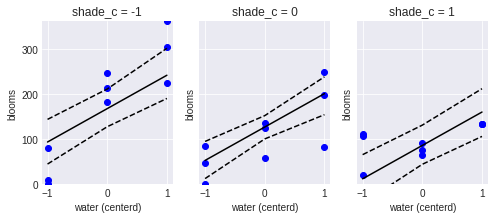

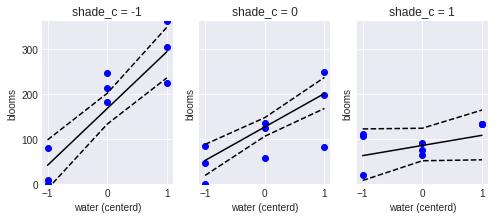

In [52]:
# No interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
water_seq = range(-1, 2, 1)

mu_s = np.zeros((len(water_seq), len(trace_7_8['a'])))
for ax, s in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.shade_c == s]
    ax.plot(dt.water-np.mean(dt.water), dt.blooms, 'bo')
    for x, iSeq in enumerate(shade_seq):
        mu_s[x] = trace_7_8['a'] + trace_7_8['bW']*iSeq + trace_7_8['bS']*s
    mu_mean_s = mu_s.mean(1)
    mu_hpd_s = pm.hpd(mu_s.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(water_seq, mu_mean_s, 'k')
    ax.plot(water_seq, mu_hpd_s.T[0], '--k')
    ax.plot(water_seq, mu_hpd_s.T[1], '--k')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('water (centerd)')
    ax.set_title('shade_c = %d'%s)
    ax.set_xticks(water_seq)
    ax.set_yticks(range(0, 301, 100))

# Interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
water_seq = range(-1, 2, 1)

mu_s = np.zeros((len(water_seq), len(trace_7_9['a'])))
for ax, s in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.shade_c == s]
    ax.plot(dt.water-np.mean(dt.water), dt.blooms, 'bo')
    for x, iSeq in enumerate(water_seq):
        mu_s[x] = trace_7_9['a'] + trace_7_9['bW']*iSeq + trace_7_9['bS']*s + trace_7_9['bWS']*iSeq*s
    mu_mean_s = mu_s.mean(1)
    mu_hpd_s = pm.hpd(mu_s.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(water_seq, mu_mean_s, 'k')
    ax.plot(water_seq, mu_hpd_s.T[0], '--k')
    ax.plot(water_seq, mu_hpd_s.T[1], '--k')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('water (centerd)')
    ax.set_title('shade_c = %d'%s)
    ax.set_xticks(water_seq)
    ax.set_yticks(range(0, 301, 100))

When there is no interaction the slope is the same across all three plots (top row), showing a general reduction with increasing shade. For the interaction (bottom row) we can see a huge increase in blooms for the lowest amount of shade as we increase water. This effect is reduced by increasing shade to average levels and in the last plot increasing water has a minimum effect when there is lots of shade.

#### 7.29

In [53]:
m_7_x = smf.ols('blooms ~ shade + water + shade * water', data=d).fit()

#### 7.30

In [54]:
m_7_x = smf.ols('blooms ~ shade * water', data=d).fit()

#### 7.31

In [55]:
m_7_x = smf.ols('blooms ~ shade * water - water', data=d).fit()

#### 7.32

In [56]:
m_7_x = smf.ols('blooms ~ shade * water * bed', data=d).fit()

#### 7.33
Not sure how this one works

In [57]:
from patsy import dmatrix
x, y, z = 1, 1, 1
d_matrix = dmatrix('~ x * y * w')
d_matrix.design_info.column_names 

['Intercept', 'x', 'y', 'x:y', 'w', 'x:w', 'y:w', 'x:y:w']

In [59]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.5.4
IPython 4.1.2
PyMC3 3.2
NumPy 1.13.3
Pandas 0.20.3
SciPy 0.19.1
Matplotlib 2.0.2

